<a href="https://colab.research.google.com/github/dunliangyang2010/AutoKeras/blob/main/Temperature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install autokeras

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import autokeras as ak

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv')
df

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8
...,...,...
3645,1990-12-27,14.0
3646,1990-12-28,13.6
3647,1990-12-29,13.5
3648,1990-12-30,15.7


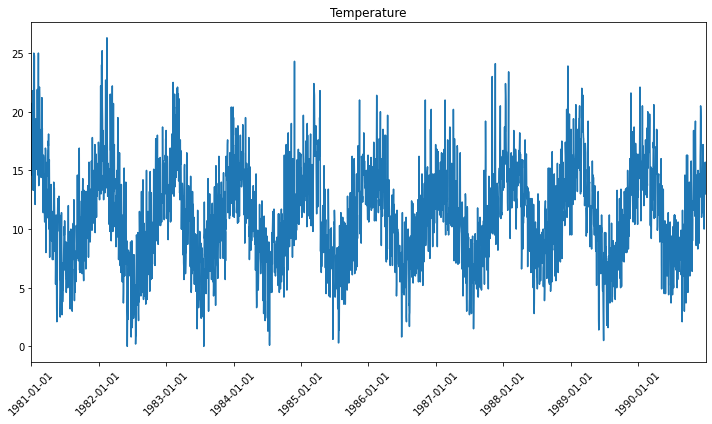

In [4]:
plt.figure(figsize=(10, 6))

date = df['Date']

plt.title('Temperature')
plt.plot(date, df['Temp'])
plt.xticks(
    ticks=date[::365].index, # x軸日期顯示以年為單位(每隔365筆資料顯示一次) 
    labels=date[::365].tolist(), rotation=45) # x軸標籤轉45度
plt.xlim([0, date.size])

plt.tight_layout()
plt.show()

# Preprocessing
資料集為單變量(univariate),
預測根據依需求,可以前一個時間點的資料為參考

In [5]:
# 新增history欄位資料,資料是根據Temp往後移一個時間點為參考
df['History'] = df['Temp'].shift(periods=1)

# 第一列History為NaN,故移除
df = df[1:]
df

,Date,Temp,History
1,1981-01-02,17.9,20.7
2,1981-01-03,18.8,17.9
3,1981-01-04,14.6,18.8
4,1981-01-05,15.8,14.6
5,1981-01-06,15.8,15.8
...,...,...,...
3645,1990-12-27,14.0,14.6
3646,1990-12-28,13.6,14.0
3647,1990-12-29,13.5,13.6
3648,1990-12-30,15.7,13.5


In [6]:
# 以history為training data, temperature為target

# 注意x取樣時的寫法,這會使x取完後,其type仍為DF而非pandas Series
# 因為autokeras對於x只接收二維的DF或ndarray的形式
x = df[['History']] 
y = df['Temp'] / 10 # target尺度縮小,以快速收斂

split = 0.2
slice_index = int(y.size * (1 - split))
x_train, x_test = x[:slice_index], x[slice_index:]
y_train, y_test = y[:slice_index], y[slice_index:]

print(x_train.shape)
print(x_test.shape)

(2919, 1)
(730, 1)


In [7]:
x

,History
1,20.7
2,17.9
3,18.8
4,14.6
5,15.8
...,...
3645,14.6
3646,14.0
3647,13.6
3648,13.5


# Model (TimeSeriesForecaster)

In [8]:
lookback = 30 # 設定要回顧的資料筆數,30表示會回顧過去30日的資料,最後再來預測氣溫
batch_size = 30 # 注意lookback的值必須被batch_size整除,否則會error(autokeras的BUG), autokeras預設batch_size為32,若不指定,則lookback必須為32倍數

reg = ak.TimeseriesForecaster(lookback=lookback, max_trials=2, overwrite=True)

reg.fit(x_train, y_train, batch_size=batch_size, callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)],epochs=300)

Trial 2 Complete [00h 01m 13s]
val_loss: 0.07289446145296097

Best val_loss So Far: 0.07289446145296097
Total elapsed time: 00h 03m 25s
INFO:tensorflow:Oracle triggered exit
Epoch 1/300
97/97 [==============================] - 11s 34ms/step - loss: 1.3119 - mean_squared_error: 1.3119
Epoch 2/300
97/97 [==============================] - 3s 33ms/step - loss: 0.4346 - mean_squared_error: 0.4346
Epoch 3/300
97/97 [==============================] - 3s 32ms/step - loss: 0.1504 - mean_squared_error: 0.1504
Epoch 4/300
97/97 [==============================] - 3s 33ms/step - loss: 0.1157 - mean_squared_error: 0.1157
Epoch 5/300
97/97 [==============================] - 3s 32ms/step - loss: 0.1066 - mean_squared_error: 0.1066
Epoch 6/300
97/97 [==============================] - 3s 32ms/step - loss: 0.0996 - mean_squared_error: 0.0996
Epoch 7/300
97/97 [==============================] - 3s 32ms/step - loss: 0.0962 - mean_squared_error: 0.0962
Epoch 8/300
97/97 [==============================] - 3s

INFO:tensorflow:Assets written to: ./time_series_forecaster/best_model/assets


INFO:tensorflow:Assets written to: ./time_series_forecaster/best_model/assets


In [ ]:
# 補充, 建立TimeSeriesForecaster物件時,也可指定預測範圍
# 設定完後,最後預測就只會回傳指定範圍的預測值
reg = ak.TimeseriesForecaster(lookback=lookback, max_trials=3, overwrite=True
                predict_from=1, # 預測時從第1個值開始
                predict_until=10, # 預測到第10個值為止
                ) # 後續預測只會預測10個值

# Evaluate
Autokeras在預測時,輸入資料必須包含"**原始資料**",  
直接傳輸入資料會跑Error

In [9]:
predicted = reg.predict(x_test).flatten()*10 # 比例要還原

ValueError: ignored

In [10]:
# 預測器物件中的屬性train_len,可以告知所需要傳入的訓練集長度
reg.train_len

2919

In [11]:
# 故呼叫predict()時,需要傳入的特徵資料為train+test,即原始的x資料集
predicted = reg.predict(x).flatten() * 10
predicted.size

121/121 [==============================] - 2s 15ms/step


700

In [12]:
from tensorflow.python.eager.context import run_eager_op_as_function_enabled
# 由predicted.size可觀察到預測值筆數為700,比原本y_test(730)少30筆
# 少30是由lookback造成,代表y_test前30筆也會被拿來做預測

# 為能將預測值與原始資料比較,原始資料前30筆不用
real = y_test[lookback:]*10
real.size

700

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

print('Prediction MSE:', mean_squared_error(real, predicted).round(3))
print('Prediction MAE:', mean_absolute_error(real, predicted).round(3))

Prediction MSE: 5.09
Prediction MAE: 1.763


# Visuallize

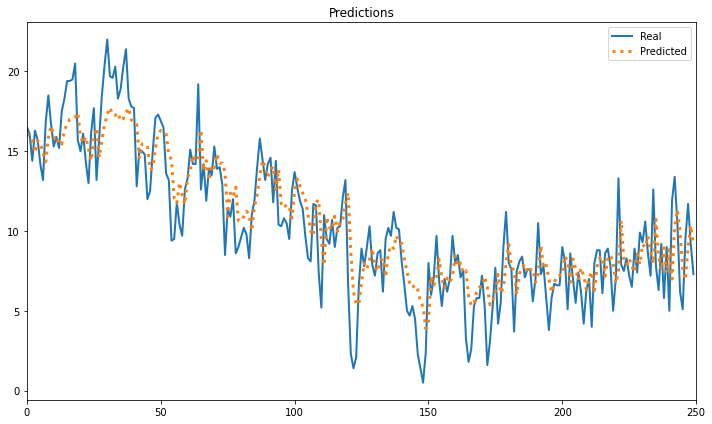

In [14]:
display_size = 250 #顯示測試集250筆資料

dx = np.arange(predicted.size)

plt.figure(figsize=(10, 6))
plt.title('Predictions')
plt.plot(dx[:display_size], real[:display_size], 
         linewidth=2, label='Real')
plt.plot(dx[:display_size], predicted[:display_size],
         linestyle='dotted', linewidth=3, label='Predicted')
plt.xlim([0, display_size]) # 設定x軸範圍
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
model = reg.export_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 1)]           0         
                                                                 
 bidirectional (Bidirectiona  (None, 30, 2)            24        
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 2)                32        
 nal)                                                            
                                                                 
 regression_head_1 (Dense)   (None, 1)                 3         
                                                                 
Total params: 59
Trainable params: 59
Non-trainable params: 0
_________________________________________________________________


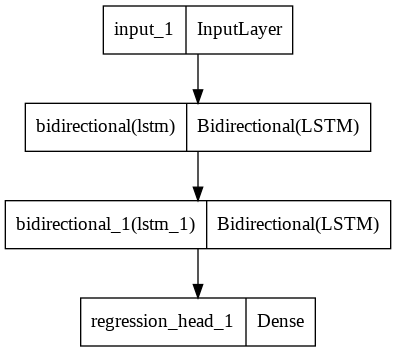

In [16]:
from tensorflow.keras.utils import plot_model
plot_model(model)